In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import tpqoa
import sys


In [2]:
# Params
day_ahead = 1
epochs = 200
lstm_units = 150
batch_size = 64


In [3]:
data = pd.read_csv('./data/EUR_USD_D_2006_2024_M.csv', parse_dates = ['time'], usecols = ['time', 'c', 'h', 'l'])

## Merge macroeco data

In [4]:
data_eco = data.copy()
data_eco.drop(['h', 'l'], axis=1, inplace=True)
data_eu_interest = pd.read_csv('./data/Interest_rate_EUR.csv')
data_ge_interest = pd.read_csv('./data/Interest_rate_Germany.csv')
data_sp500 = pd.read_csv('./data/SP500_Historical_Data.csv', parse_dates = ['Date'])
data_cpi = pd.read_csv('./data/CPI-U_Inflation_US.csv')
data_dff = pd.read_csv('./data/DFF.csv')
data_gdaxi = pd.read_csv('./data/GDAXI.csv')
data_hcip = pd.read_csv('./data/HCIP_Inflation_EUR.csv')


In [5]:
data_eco['year_month'] = data_eco['time'].dt.strftime('%Y-%m')

In [6]:
# Merge with data_eu_interest
data_eu_interest['DATE'] = pd.to_datetime(data_eu_interest['DATE'], format="%Y-%m-%d").dt.strftime("%Y-%m")
data_eco = pd.merge(data_eco, data_eu_interest, left_on='year_month', right_on='DATE', how='left')
data_eco.drop(['DATE', 'TIME PERIOD'], axis=1, inplace=True)

In [7]:
# Merge with data_ge_interest
data_ge_interest['DATE'] = pd.to_datetime(data_ge_interest['DATE'], format="%Y-%m-%d").dt.strftime("%Y-%m")
data_eco = pd.merge(data_eco, data_ge_interest, left_on='year_month', right_on='DATE', how='left')
data_eco.drop(['DATE', 'TIME PERIOD'], axis=1, inplace=True)

In [8]:
# Merge with data_sp500
data_eco = pd.merge(data_eco, data_sp500[['Date', 'Adj Close']], left_on='time', right_on='Date', how='left')
data_eco.drop(['Date'], axis=1, inplace=True)
data_eco['Adj Close'].interpolate(method='linear', inplace=True)
data_eco['Adj Close'].bfill(inplace=True)
data_eco.rename(columns= {'Adj Close' : 'sp500'}, inplace=True)

In [9]:
# Merge with data_cpi
data_cpi = data_cpi[~data_cpi['Period'].isin(['S01', 'S02'])]
data_cpi['year_month'] = data_cpi['Year'].astype(str) + '-' + pd.to_datetime(data_cpi['Period'], format="M%m").dt.strftime('%m')
data_eco = pd.merge(data_eco, data_cpi[['year_month', 'Value']], left_on='year_month', right_on='year_month', how='left')
data_eco.rename(columns= {'Value' : 'cpi-u'}, inplace=True)

In [10]:
# Merge with data_dff
data_dff['DATE'] = pd.to_datetime(data_dff['DATE'], format='%Y-%m-%d')
data_eco = pd.merge(data_eco, data_dff[['DATE', 'DFF']], left_on='time', right_on='DATE', how='left')
data_eco.rename(columns= {'Value' : 'cpi-u'}, inplace=True)
data_eco.drop(['DATE'], axis=1, inplace=True)


In [11]:
# Merge with data_gdaxi
data_gdaxi['Date'] = pd.to_datetime(data_gdaxi['Date'], format='%Y-%m-%d')
data_eco = pd.merge(data_eco, data_gdaxi[['Date', 'Adj Close']], left_on='time', right_on='Date', how='left')
data_eco.rename(columns= {'Adj Close' : 'gdaxi'}, inplace=True)
data_eco.drop(['Date'], axis=1, inplace=True)
data_eco['gdaxi'].interpolate(method='linear', inplace=True)


In [12]:
# Merge with data_hcip
data_hcip['DATE'] = pd.to_datetime(data_hcip['DATE'], format="%Y-%m-%d").dt.strftime("%Y-%m")
data_eco = pd.merge(data_eco, data_hcip, left_on='year_month', right_on='DATE', how='left')
data_eco.drop(['DATE', 'TIME PERIOD'], axis=1, inplace=True)
data_eco

,time,c,year_month,interest_rate_eu,interest_rate_ge,sp500,cpi-u,DFF,gdaxi,hcip
0,2006-01-02,1.18380,2006-01,3.38,3.32,1268.800049,2.1,4.09,5449.979980,2.4
1,2006-01-03,1.18420,2006-01,3.38,3.32,1268.800049,2.1,4.34,5460.680176,2.4
2,2006-01-04,1.20310,2006-01,3.38,3.32,1273.459961,2.1,4.22,5523.620117,2.4
3,2006-01-05,1.21140,2006-01,3.38,3.32,1273.479980,2.1,4.24,5516.529785,2.4
4,2006-01-06,1.21140,2006-01,3.38,3.32,1285.449951,2.1,4.22,5536.319824,2.4
...,...,...,...,...,...,...,...,...,...,...
4733,2024-03-25,1.08030,2024-03,2.90,2.35,5218.189941,3.8,5.33,18261.310547,2.4
4734,2024-03-26,1.08385,2024-03,2.90,2.35,5203.580078,3.8,5.33,18384.349609,2.4
4735,2024-03-27,1.08302,2024-03,2.90,2.35,5248.490234,3.8,5.33,18477.089844,2.4
4736,2024-03-28,1.08138,2024-03,2.90,2.35,5254.350098,3.8,5.33,18492.490234,2.4


In [13]:
# Drop the first 26 rows to match with data_tech
data_eco = data_eco.iloc[26:]
print(data_eco.shape)
print(data_eco)
print(data_eco.isna().sum())

(4712, 10)
           time        c year_month  interest_rate_eu  interest_rate_ge  \
26   2006-02-07  1.19646    2006-02              3.53              3.47   
27   2006-02-08  1.19816    2006-02              3.53              3.47   
28   2006-02-09  1.19626    2006-02              3.53              3.47   
29   2006-02-10  1.19840    2006-02              3.53              3.47   
30   2006-02-13  1.18960    2006-02              3.53              3.47   
...         ...      ...        ...               ...               ...   
4733 2024-03-25  1.08030    2024-03              2.90              2.35   
4734 2024-03-26  1.08385    2024-03              2.90              2.35   
4735 2024-03-27  1.08302    2024-03              2.90              2.35   
4736 2024-03-28  1.08138    2024-03              2.90              2.35   
4737 2024-03-29  1.07866    2024-03              2.90              2.35   

            sp500  cpi-u   DFF         gdaxi  hcip  
26    1254.780029    2.1  4.47   56

## Determine threshold

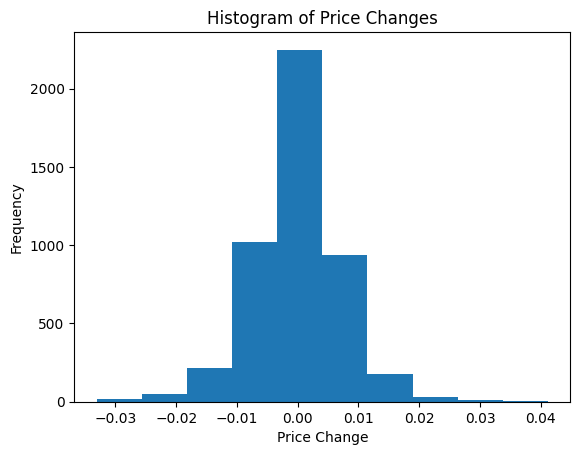

In [14]:
# Calculate price changes
price_changes = np.diff(data_eco['c'])

# Perform histogram analysis
histogram, bins = np.histogram(price_changes, bins=10)

# Plot histogram
plt.bar(bins[:-1], histogram, width=np.diff(bins), align='edge')
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.title('Histogram of Price Changes')
plt.show()

In [15]:
price_changes

array([ 0.0017 , -0.0019 ,  0.00214, ..., -0.00083, -0.00164, -0.00272])

In [16]:
import numpy as np

# Determine number of bins
number_of_bins = 10

# Calculate histogram
histogram, bins = np.histogram(price_changes, bins=number_of_bins, range=(0, price_changes.max()))

# Sort histogram counts in descending order
sorted_histogram = np.sort(histogram)[::-1]

# Calculate cumulative sum of sorted histogram counts
cumulative_sum = np.cumsum(sorted_histogram)

# Find the index where cumulative sum exceeds 85% of the whole count
index_85_percent = np.argmax(cumulative_sum >= len(price_changes) * 0.85)

# Calculate the upper bound of the threshold value
if index_85_percent == 0:
    threshold_upper_bound = bins[-1]
else:
    threshold_upper_bound = bins[index_85_percent]

print("Upper bound of the threshold value:", threshold_upper_bound)

Upper bound of the threshold value: 0.04116999999999993


In [17]:
bin_counts, bin_edges = np.histogram(price_changes, bins=number_of_bins)
print(bin_counts)
print(bin_edges)
bin_max_diff = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_counts))]
print(bin_max_diff)

[  17   49  213 1022 2249  939  177   28   14    3]
[-0.03304  -0.025619 -0.018198 -0.010777 -0.003356  0.004065  0.011486
  0.018907  0.026328  0.033749  0.04117 ]
[-0.029329500000000175, -0.021908500000000164, -0.014487500000000153, -0.007066500000000142, 0.0003544999999998688, 0.00777549999999988, 0.01519649999999989, 0.0226174999999999, 0.030038499999999912, 0.03745949999999992]


In [18]:
import numpy as np

def histogram_analysis(close_diff, number_of_bins):
    # Perform histogram analysis
    bin_counts, bin_edges = np.histogram(close_diff, bins=number_of_bins)
    bin_max_diff = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_counts))]

    # Sort bin_counts and bin_max_diff in descending order
    sorted_indices = np.argsort(bin_counts)[::-1]
    bin_counts = bin_counts[sorted_indices]
    bin_max_diff = [bin_max_diff[i] for i in sorted_indices]

    # Calculate sum of bin_counts
    sum_bin_counts = np.sum(bin_counts)

    # Find the threshold upper bound
    temp_sum = 0
    for i in range(number_of_bins):
        temp_sum += bin_counts[i]
        if temp_sum / sum_bin_counts > 0.85:
            break

    threshold_upper_bound = bin_max_diff[i]

    return threshold_upper_bound

# Example usage
# close_diff = np.random.uniform(low=-0.01, high=0.01, size=1000)  # Example differences data
number_of_bins = 10  # Example number of bins
threshold_upper_bound = histogram_analysis(price_changes, number_of_bins)
print("Threshold upper bound:", threshold_upper_bound)


Threshold upper bound: 0.00777549999999988


In [19]:
import numpy as np

def calculate_threshold(close_diff):
    # Get the upper bound of the threshold value from histogram analysis
    threshold_upper_bound = histogram_analysis(close_diff, number_of_bins)
    
    temp_threshold = 0
    best_entropy = -float('inf')
    threshold = None
    
    while temp_threshold < threshold_upper_bound:
        labels = np.zeros(len(close_diff))  # Initialize labels with zeros
        
        # Assign labels based on threshold
        indexes_incr = np.where(close_diff > temp_threshold)[0]
        indexes_decr = np.where(-close_diff > temp_threshold)[0]
        labels[indexes_incr] = 2
        labels[indexes_decr] = 1
        
        # Calculate entropy
        entropy = calculate_entropy(labels)
        
        # Update best_entropy and threshold if current entropy is better
        if entropy > best_entropy:
            best_entropy = entropy
            threshold = temp_threshold
        
        # Increase temp_threshold for next iteration
        temp_threshold += 0.00001
    
    return threshold

# Function to calculate entropy
def calculate_entropy(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    probabilities = label_counts / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Example usage
threshold = calculate_threshold(price_changes)
print("Final threshold:", threshold)


Final threshold: 0.0024400000000000055


## Data preprocess

In [20]:
data_tech = data.copy()
data_tech['MA_10'] = ta.sma(data_tech['c'], length=10)
data_tech['MACD_12_26'] = ta.macd(data_tech['c'], fast=12, slow=26).iloc[:, 0]
data_tech['ROC_2'] = ta.roc(data_tech['c'], length=2)
data_tech['Momentum_4'] = ta.mom(data_tech['c'], length=4)
data_tech['RSI_10'] = ta.rsi(data_tech['c'], length=10)
bb_data = ta.bbands(data_tech['c'], length=20)
data_tech = pd.concat([data_tech, bb_data], axis=1)
data_tech['CCI_20'] = ta.cci(data_tech['h'], data_tech['l'], data_tech['c'], length=20)
data_tech = data_tech.iloc[26:]
data_tech['price_diff'] = data_tech['c'].diff()
data_tech['price_diff'] = data_tech['price_diff'].bfill()
data_tech['target'] = 0
data_tech.loc[data_tech['price_diff'] > threshold, 'target'] = 2
data_tech.loc[data_tech['price_diff'] < -threshold, 'target'] = 1
data_tech['target'] = data_tech['target'].shift(-day_ahead)
data_tech['target'].fillna(0, inplace=True)
data_tech.set_index('time', inplace=True)
data_tech.drop(['h', 'l', 'price_diff'], axis=1, inplace=True)
# print(data_tech.isna().sum())
data_tech

,c,MA_10,MACD_12_26,ROC_2,Momentum_4,RSI_10,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,CCI_20,target
time,,,,,,,,,,,,,
2006-02-07,1.19646,1.212396,-0.000074,-1.045406,-0.01834,36.217972,1.196244,1.212436,1.228628,2.671004,0.006673,-165.533230,0.0
2006-02-08,1.19816,1.209542,-0.000946,-0.485050,-0.00964,38.532998,1.194933,1.212059,1.229185,2.825944,0.094215,-133.416803,0.0
2006-02-09,1.19626,1.206658,-0.001769,-0.016716,-0.01284,36.871095,1.192758,1.211187,1.229616,3.043199,0.095022,-137.805786,0.0
2006-02-10,1.19840,1.204328,-0.002223,0.020031,-0.00560,40.103967,1.191852,1.210892,1.229932,3.144742,0.171949,-105.776085,1.0
2006-02-13,1.18960,1.202308,-0.003255,-0.556735,-0.00686,32.499577,1.188575,1.209562,1.230549,3.470244,0.024428,-167.999552,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,1.08030,1.089076,0.000777,-1.178214,-0.00694,38.811259,1.078868,1.087952,1.097036,1.669874,0.078807,-128.014550,2.0
2024-03-26,1.08385,1.088139,0.000427,-0.253083,-0.00212,45.143745,1.078728,1.087897,1.097066,1.685578,0.279303,-70.215176,0.0
2024-03-27,1.08302,1.087145,0.000082,0.251782,-0.01016,43.961831,1.078553,1.087835,1.097117,1.706560,0.240635,-80.347630,0.0


In [21]:
data_eco['price_diff'] = data_eco['c'].diff()
data_eco['price_diff'] = data_eco['price_diff'].bfill()
data_eco['target'] = 0
data_eco.loc[data_eco['price_diff'] > threshold, 'target'] = 2
data_eco.loc[data_eco['price_diff'] < -threshold, 'target'] = 1
data_eco['target'] = data_eco['target'].shift(-day_ahead)
data_eco['target'].fillna(0, inplace=True)
data_eco.set_index('time', inplace=True)
data_eco.drop(['year_month', 'price_diff'], axis=1, inplace=True)

/tmp/ipykernel_533055/2160447692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eco['price_diff'] = data_eco['c'].diff()
/tmp/ipykernel_533055/2160447692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eco['price_diff'] = data_eco['price_diff'].bfill()
/tmp/ipykernel_533055/2160447692.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## Train model

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def data_normalized(X, y, test_size=0.2):
    # Split the dataset into training and testing sets with no shuffling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler to the training data and transform it
    X_train_normalized = scaler.fit_transform(X_train)

    # Transform the testing data using the scaler fitted on the training data
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, X_test_normalized, y_train, y_test


In [23]:
from keras.metrics import Metric
import keras.backend as K

class ProfitAccuracy(Metric):
    def __init__(self, **kwargs):
        super(ProfitAccuracy, self).__init__(**kwargs)
        self.true_dec = self.add_weight(name='true_dec', initializer='zeros')
        self.true_inc = self.add_weight(name='true_inc', initializer='zeros')
        self.false_dec_noact = self.add_weight(name='false_dec_noact', initializer='zeros')
        self.false_inc_noact = self.add_weight(name='false_inc_noact', initializer='zeros')
        self.false_inc_dec = self.add_weight(name='false_inc_dec', initializer='zeros')
        self.false_dec_inc = self.add_weight(name='false_dec_inc', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert y_true and y_pred to boolean arrays
        y_true = K.argmax(y_true, axis=-1)
        y_pred = K.argmax(y_pred, axis=-1)
        
        true_dec = K.sum(K.cast(K.equal(y_true, 1) & K.equal(y_pred, 1), 'float32'))
        true_inc = K.sum(K.cast(K.equal(y_true, 2) & K.equal(y_pred, 2), 'float32'))
        false_dec_noact = K.sum(K.cast(K.equal(y_true, 0) & K.equal(y_pred, 1), 'float32'))
        false_inc_noact = K.sum(K.cast(K.equal(y_true, 0) & K.equal(y_pred, 2), 'float32'))
        false_inc_dec = K.sum(K.cast(K.equal(y_true, 1) & K.equal(y_pred, 2), 'float32'))
        false_dec_inc = K.sum(K.cast(K.equal(y_true, 2) & K.equal(y_pred, 1), 'float32'))


        self.true_dec.assign_add(true_dec)
        self.true_inc.assign_add(true_inc)
        self.false_dec_noact.assign_add(false_dec_noact)
        self.false_inc_noact.assign_add(false_inc_noact)
        self.false_inc_dec.assign_add(false_inc_dec)
        self.false_dec_inc.assign_add(false_dec_inc)

    def result(self):
        numerator = self.true_dec + self.true_inc
        denominator = (
            self.false_dec_noact + self.false_inc_noact +
            self.true_dec + self.false_inc_dec +
            self.false_dec_inc + self.true_inc
        )

        # Check for division by zero
        if denominator == 0:
            return 0.0
        else:
            return numerator / denominator

    def reset_state(self):
        self.true_dec.assign(0)
        self.true_inc.assign(0)
        self.false_dec_noact.assign(0)
        self.false_inc_noact.assign(0)
        self.false_inc_dec.assign(0)
        self.false_dec_inc.assign(0)


2024-04-26 03:12:00.367247: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 03:12:00.391571: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 03:12:00.684836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 03:12:00.684973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 03:12:00.720938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [24]:
# X_train_normalized

In [25]:
X_eco = data_eco.drop(columns=['target'])
y_eco = data_eco['target']

X_train_normalized_eco, X_test_normalized_eco, y_train, y_test = data_normalized(X_eco, y_eco)
y_train

time
2006-02-07    0.0
2006-02-08    0.0
2006-02-09    0.0
2006-02-10    1.0
2006-02-13    0.0
             ... 
2020-08-05    2.0
2020-08-06    0.0
2020-08-07    1.0
2020-08-10    1.0
2020-08-11    0.0
Name: target, Length: 3769, dtype: float64

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# from keras.layers import Dropout

def train_lstm_model(X_train, X_test, y_train, y_test, lstm_units=lstm_units, epochs=epochs, batch_size=batch_size):
    # Convert features to float32
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # Convert labels to one-hot encoding
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_y_train = encoder.transform(y_train)
    encoded_y_test = encoder.transform(y_test)
    y_train_onehot = to_categorical(encoded_y_train)
    y_test_onehot = to_categorical(encoded_y_test)

    # Reshape input data for LSTM
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[ProfitAccuracy()])

    # Train the model
    model.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_onehot))
    
    # Evaluate the model on the test set using custom metric
    y_pred = model.predict(X_test)
    profit_accuracy = ProfitAccuracy()(y_test_onehot, y_pred)
    print(f"Profit_accuracy = {profit_accuracy}")

    return y_pred, profit_accuracy



In [27]:
y_eco = data_eco['target']
X_eco = data_eco.drop(columns=['target'])

X_train_normalized_eco, X_test_normalized_eco, y_train, y_test = data_normalized(X_eco, y_eco)
y_pred, profit_accuracy = train_lstm_model(X_train_normalized_eco, X_test_normalized_eco, y_train, y_test)

Epoch 1/200
59/59 [==============================] - 3s 17ms/step - loss: 1.0922 - profit_accuracy: 0.3560 - val_loss: 1.0843 - val_profit_accuracy: 0.0000e+00
Epoch 2/200
59/59 [==============================] - 0s 7ms/step - loss: 1.0832 - profit_accuracy: 0.3716 - val_loss: 1.0850 - val_profit_accuracy: 0.0000e+00
Epoch 3/200
59/59 [==============================] - 0s 7ms/step - loss: 1.0802 - profit_accuracy: 0.3734 - val_loss: 1.1081 - val_profit_accuracy: 0.0000e+00
Epoch 4/200
59/59 [==============================] - 0s 7ms/step - loss: 1.0788 - profit_accuracy: 0.3722 - val_loss: 1.1051 - val_profit_accuracy: 0.0000e+00
Epoch 5/200
59/59 [==============================] - 0s 7ms/step - loss: 1.0784 - profit_accuracy: 0.3851 - val_loss: 1.1377 - val_profit_accuracy: 0.0000e+00
Epoch 6/200
59/59 [==============================] - 0s 6ms/step - loss: 1.0782 - profit_accuracy: 0.3835 - val_loss: 1.1234 - val_profit_accuracy: 0.0000e+00
Epoch 7/200
59/59 [==========================

In [28]:
y_tech = data_tech['target']
X_tech = data_tech.drop(columns=['target'])

X_train_normalized_tech, X_test_normalized_tech, y_train, y_test = data_normalized(X_tech, y_tech)
y_pred, profit_accuracy = train_lstm_model(X_train_normalized_tech, X_test_normalized_tech, y_train, y_test)

Epoch 1/200
59/59 [==============================] - 2s 13ms/step - loss: 1.0960 - profit_accuracy_2: 0.3407 - val_loss: 1.0967 - val_profit_accuracy_2: 0.2848
Epoch 2/200
59/59 [==============================] - 0s 6ms/step - loss: 1.0919 - profit_accuracy_2: 0.3541 - val_loss: 1.0981 - val_profit_accuracy_2: 0.2803
Epoch 3/200
59/59 [==============================] - 0s 6ms/step - loss: 1.0888 - profit_accuracy_2: 0.3575 - val_loss: 1.0901 - val_profit_accuracy_2: 1.0000
Epoch 4/200
59/59 [==============================] - 0s 7ms/step - loss: 1.0860 - profit_accuracy_2: 0.3681 - val_loss: 1.0910 - val_profit_accuracy_2: 0.3571
Epoch 5/200
59/59 [==============================] - 0s 6ms/step - loss: 1.0844 - profit_accuracy_2: 0.3635 - val_loss: 1.0897 - val_profit_accuracy_2: 0.2759
Epoch 6/200
59/59 [==============================] - 0s 7ms/step - loss: 1.0825 - profit_accuracy_2: 0.3704 - val_loss: 1.0938 - val_profit_accuracy_2: 0.3158
Epoch 7/200
59/59 [==========================

In [29]:
def combine_predictions(me_pred_probs, ti_pred_probs):
    combined_pred_probs = []

    for me_probs, ti_probs in zip(me_pred_probs, ti_pred_probs):
        # If one model's prediction is class_noact, set final decision as class_noact
        if np.argmax(me_probs) == 0 or np.argmax(ti_probs) == 0:
            combined_pred_probs.append([1, 0, 0])  # class_noact one-hot encoding
        # If both models agree on labels, set final decision as this label
        elif np.argmax(me_probs) == np.argmax(ti_probs):
            combined_pred_probs.append(me_probs)  # Use either model's probabilities
        # If predictions of the two models are different, choose the one with higher probability
        else:
            max_prob_index = np.argmax([np.max(me_probs), np.max(ti_probs)])
            if max_prob_index == 0:
                combined_pred_probs.append(me_probs)  # Use ME_LSTM's probabilities
            else:
                combined_pred_probs.append(ti_probs)  # Use TI_LSTM's probabilities

    return np.array(combined_pred_probs)


def train_lstm_model_combine(X_train_eco, X_test_eco, X_train_tech, X_test_tech, y_train, y_test, lstm_units=lstm_units, epochs=epochs, batch_size=batch_size):
    # Train ME_LSTM model
    me_pred_probs, _ = train_lstm_model(X_train_eco, X_test_eco, y_train, y_test, lstm_units, epochs, batch_size)

    # Train TI_LSTM model
    # ti_pred_probs, _ = train_lstm_model(X_train_tech, X_test_tech, y_train, y_test, lstm_units, epochs, batch_size)
    ti_pred_probs, _ = train_lstm_model(X_train_tech, X_test_tech, y_train, y_test, lstm_units, epochs, batch_size)

    # Combine predictions
    combined_pred_probs = combine_predictions(me_pred_probs, ti_pred_probs)

    # Convert y_test to one-hot encoding
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_y_test = encoder.transform(y_test)
    y_test_onehot = to_categorical(encoded_y_test)

    # Evaluate the combined model using ProfitAccuracy metric
    profit_accuracy = ProfitAccuracy()(y_test_onehot, combined_pred_probs)
    print(f"Combine profit_accuracy = {profit_accuracy}")

    return combined_pred_probs, profit_accuracy


In [30]:
combined_pred_probs, profit_accuracy = train_lstm_model_combine(X_train_normalized_eco, X_test_normalized_eco, X_train_normalized_tech, X_test_normalized_tech, y_train, y_test)

Epoch 1/200
59/59 [==============================] - 2s 13ms/step - loss: 1.0919 - profit_accuracy_4: 0.3625 - val_loss: 1.0821 - val_profit_accuracy_4: 0.2500
Epoch 2/200
59/59 [==============================] - 0s 6ms/step - loss: 1.0836 - profit_accuracy_4: 0.3747 - val_loss: 1.0840 - val_profit_accuracy_4: 0.0000e+00
Epoch 3/200
59/59 [==============================] - 0s 7ms/step - loss: 1.0802 - profit_accuracy_4: 0.3920 - val_loss: 1.1129 - val_profit_accuracy_4: 0.0000e+00
Epoch 4/200
59/59 [==============================] - 0s 7ms/step - loss: 1.0791 - profit_accuracy_4: 0.3710 - val_loss: 1.1164 - val_profit_accuracy_4: 0.0000e+00
Epoch 5/200
59/59 [==============================] - 0s 7ms/step - loss: 1.0785 - profit_accuracy_4: 0.3838 - val_loss: 1.0975 - val_profit_accuracy_4: 0.0000e+00
Epoch 6/200
59/59 [==============================] - 0s 6ms/step - loss: 1.0779 - profit_accuracy_4: 0.3841 - val_loss: 1.1144 - val_profit_accuracy_4: 0.0000e+00
Epoch 7/200
59/59 [======